# Prediction of dynamical systems

**Author:** M.G. Baltussen

**Estimated running time:** 20 minutes (including compilation of the Amici module, this can be disabled after the first run)

**Generated output:**
```
plots/dynamics_predictions.{svg,png} (manuscript figure 3)
plots/dynamics_score.{svg,png} (manuscript figure 3)

plots_extended/si_dynamics_full.{svg,png}
plots_extended/si_dynamics_predictions_a.{svg,png}
plots_extended/si_dynamics_predictions_b.{svg,png}
plots_extended/si_dynamics_errors.{svg,png}

./CCM_ext_Gly_mod.xml (downloaded by the notebook from [biomodels.com](https://www.ebi.ac.uk/biomodels/))
./amici-CCM_ext_Gly_mod (generated folder, contains Amici-compiled C++ model)
```

## Imports

In [1]:
""" System imports """
import pathlib
import toml

""" Essential imports"""
import numpy as np
import pandas as pd

""" ML/RC imports """
from sklearn.feature_selection import mutual_info_regression as mi_reg
from sklearn import linear_model, model_selection, preprocessing, svm
from sklearn import metrics

from pyrcn.echo_state_network import ESNClassifier


""" Visualization imports and settings"""
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import seaborn as sns; sns.set_theme(style='ticks', context='paper', font_scale=0.7, 
rc={
    "axes.linewidth": 0.5,     
    'axes.facecolor':'#eceff4', 
    'axes.edgecolor':'#2e3440',
    'axes.labelcolor':'#2e3440',
    'text.color': '#2e3440',
    'xtick.color': '#2e3440',
    'ytick.color': '#2e3440',
    'font.family': 'Arial',
    'svg.fonttype': 'none',
    })
import colorcet as cc

nord_palette = [
    "#bf616a","#d08770","#ebcb8b","#a3be8c","#b48ead",
    "#8fbcbb","#88c0d0","#81a1c1","#5e81ac",
    "#2e3440","#3b4252","#434c5e","#4c566a",
    "#d8dee9","#e5e9f0","#eceff4",
]

sns.set_palette(nord_palette)

def save_plot(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots/{name}.svg", **kwargs)
    plt.savefig(f"../plots/{name}.png", dpi=600, **kwargs)

def save_si(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots_extended/{name}.svg", **kwargs)
    plt.savefig(f"../plots_extended/{name}.png", dpi=600, **kwargs)


## Data loading

In [2]:
df_all = pd.read_csv("../data/fluctuations.csv", index_col=0)
df_all.index = df_all.index / 60 # minutes
U_fluctuations = df_all['DHA']/0.725 # mM

X = df_all.drop(columns=['DHA', 'NaOH', 'CaCl2', 'formaldehyde'])

## Plots figure 3b

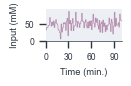

In [3]:
fig, axes = plt.subplots(figsize=(1.2, 0.75), constrained_layout=True)

axes.plot(U_fluctuations.index[:720], U_fluctuations.values[:720], alpha=1.0, lw=0.5, color='#b48ead')

axes.set_xticks([20, 50, 80, 110], [0, 30, 60, 90])
axes.set_xlim(20, 120)
# axes.set_yticks([])
axes.set_ylim(0)
axes.set_xlabel("Time (min.)")
axes.set_ylabel("Input (mM)")

sns.despine(left=True)
save_plot("dynamics_input")
plt.show()

# Load/modify/compile SBML model

In [4]:
import tellurium as te
import amici
import libsbml

r = te.loadSBMLModel('https://ftp.ebi.ac.uk/pub/databases/biomodels/repository/aaj/MODEL2010160002/3/CCM_ext_Gly.xml') # E. coli glycerol Oliveira 2020

r.addParameter("kf", 1.0)
for s, c in zip(r.getFloatingSpeciesIds(), r.getFloatingSpeciesConcentrations()):
    r.addSpeciesConcentration(f"{s}_in", compartment='cell', initConcentration=c, boundaryCondition=True)
    r.addReaction(f"F_{s}_in", [], [s], f"kf*{s}_in")
    r.addReaction(f"F_{s}_out", [s], [], f"kf*{s}")
r.exportToSBML("CCM_ext_Gly_mod.xml")


In [5]:
sbml_doc = libsbml.SBMLReader().readSBML('CCM_ext_Gly_mod.xml')
sbml_model = sbml_doc.getModel()

sbml_importer = amici.SbmlImporter(sbml_model)

sbml_importer.sbml2amici(model_name="CCM_ext_Gly_mod", output_dir='amici-CCM_ext_Gly_mod', verbose=True, compile=True) # If module has been compiled before, this line can be disable to skip compilation
model_module = amici.import_model_module("CCM_ext_Gly_mod", "amici-CCM_ext_Gly_mod")
model = model_module.getModel()

ORIGINAL_STATES = model.getInitialStates()

2024-04-24 10:40:19.435 - amici.sbml_import - DEBUG - Finished processing SBML annotations         + (2.40E-03s)


DEBUG:amici.sbml_import:Finished processing SBML annotations         + (2.40E-03s)


2024-04-24 10:40:20.218 - amici.sbml_import - DEBUG - Finished gathering local SBML symbols        + (7.69E-01s)


DEBUG:amici.sbml_import:Finished gathering local SBML symbols        + (7.69E-01s)


2024-04-24 10:40:20.246 - amici.sbml_import - DEBUG - Finished processing SBML parameters          + (1.12E-02s)


DEBUG:amici.sbml_import:Finished processing SBML parameters          + (1.12E-02s)


2024-04-24 10:40:20.263 - amici.sbml_import - DEBUG - Finished processing SBML compartments        + (5.08E-04s)


DEBUG:amici.sbml_import:Finished processing SBML compartments        + (5.08E-04s)


2024-04-24 10:40:20.409 - amici.sbml_import - DEBUG - Finished processing SBML species initials   ++ (1.05E-01s)


DEBUG:amici.sbml_import:Finished processing SBML species initials   ++ (1.05E-01s)


2024-04-24 10:40:20.430 - amici.sbml_import - DEBUG - Finished processing SBML rate rules         ++ (9.39E-05s)


DEBUG:amici.sbml_import:Finished processing SBML rate rules         ++ (9.39E-05s)


2024-04-24 10:40:20.434 - amici.sbml_import - DEBUG - Finished processing SBML species             + (1.53E-01s)


DEBUG:amici.sbml_import:Finished processing SBML species             + (1.53E-01s)


2024-04-24 10:40:20.660 - amici.sbml_import - DEBUG - Finished processing SBML reactions           + (2.06E-01s)


DEBUG:amici.sbml_import:Finished processing SBML reactions           + (2.06E-01s)


2024-04-24 10:40:20.790 - amici.sbml_import - DEBUG - Finished processing SBML rules               + (1.12E-01s)


DEBUG:amici.sbml_import:Finished processing SBML rules               + (1.12E-01s)


2024-04-24 10:40:20.811 - amici.sbml_import - DEBUG - Finished processing SBML events              + (2.85E-04s)


DEBUG:amici.sbml_import:Finished processing SBML events              + (2.85E-04s)


2024-04-24 10:40:20.827 - amici.sbml_import - DEBUG - Finished processing SBML initial assignments + (3.52E-05s)


DEBUG:amici.sbml_import:Finished processing SBML initial assignments + (3.52E-05s)


2024-04-24 10:40:20.844 - amici.sbml_import - DEBUG - Finished processing SBML species references  + (2.48E-03s)


DEBUG:amici.sbml_import:Finished processing SBML species references  + (2.48E-03s)


2024-04-24 10:40:20.846 - amici.sbml_import - INFO - Finished importing SBML                         (1.42E+00s)


INFO:amici.sbml_import:Finished importing SBML                         (1.42E+00s)


2024-04-24 10:40:21.816 - amici.sbml_import - INFO - Finished processing SBML observables            (9.53E-01s)


INFO:amici.sbml_import:Finished processing SBML observables            (9.53E-01s)


2024-04-24 10:40:21.830 - amici.sbml_import - INFO - Finished processing SBML event observables      (2.93E-06s)


INFO:amici.sbml_import:Finished processing SBML event observables      (2.93E-06s)


2024-04-24 10:40:22.778 - amici.de_export - DEBUG - Finished running smart_multiply                + (3.03E-02s)


DEBUG:amici.de_export:Finished running smart_multiply                + (3.03E-02s)


2024-04-24 10:53:39.076 - amici.de_export - DEBUG - Finished simplifying xdot                     ++ (1.02E-01s)


DEBUG:amici.de_export:Finished simplifying xdot                     ++ (1.02E-01s)


2024-04-24 10:53:39.078 - amici.de_export - DEBUG - Finished computing xdot                        + (1.10E-01s)


DEBUG:amici.de_export:Finished computing xdot                        + (1.10E-01s)


2024-04-24 10:53:39.174 - amici.de_export - DEBUG - Finished simplifying x0                       ++ (1.73E-03s)


DEBUG:amici.de_export:Finished simplifying x0                       ++ (1.73E-03s)


2024-04-24 10:53:39.175 - amici.de_export - DEBUG - Finished computing x0                          + (1.59E-02s)


DEBUG:amici.de_export:Finished computing x0                          + (1.59E-02s)


2024-04-24 10:53:39.199 - amici.de_export - INFO - Finished importing SbmlImporter                   (7.96E+02s)


INFO:amici.de_export:Finished importing SbmlImporter                   (7.96E+02s)


2024-04-24 10:53:41.558 - amici.de_export - DEBUG - Finished simplifying Jy                      +++ (2.31E+00s)


DEBUG:amici.de_export:Finished simplifying Jy                      +++ (2.31E+00s)


2024-04-24 10:53:41.559 - amici.de_export - DEBUG - Finished computing Jy                         ++ (2.32E+00s)


DEBUG:amici.de_export:Finished computing Jy                         ++ (2.32E+00s)


2024-04-24 10:53:42.434 - amici.de_export - DEBUG - Finished simplifying y                       +++ (1.14E-02s)


DEBUG:amici.de_export:Finished simplifying y                       +++ (1.14E-02s)


2024-04-24 10:53:42.435 - amici.de_export - DEBUG - Finished computing y                          ++ (2.16E-02s)


DEBUG:amici.de_export:Finished computing y                          ++ (2.16E-02s)


2024-04-24 10:53:42.472 - amici.de_export - DEBUG - Finished simplifying sigmay                  +++ (1.97E-03s)


DEBUG:amici.de_export:Finished simplifying sigmay                  +++ (1.97E-03s)


2024-04-24 10:53:42.473 - amici.de_export - DEBUG - Finished computing sigmay                     ++ (2.24E-02s)


DEBUG:amici.de_export:Finished computing sigmay                     ++ (2.24E-02s)


2024-04-24 10:53:42.475 - amici.de_export - DEBUG - Finished writing Jy.cpp                        + (3.25E+00s)


DEBUG:amici.de_export:Finished writing Jy.cpp                        + (3.25E+00s)


2024-04-24 10:53:45.015 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (2.50E+00s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (2.50E+00s)


2024-04-24 10:53:46.694 - amici.de_export - DEBUG - Finished simplifying dJydsigma               +++ (1.66E+00s)


DEBUG:amici.de_export:Finished simplifying dJydsigma               +++ (1.66E+00s)


2024-04-24 10:53:46.695 - amici.de_export - DEBUG - Finished computing dJydsigma                  ++ (4.19E+00s)


DEBUG:amici.de_export:Finished computing dJydsigma                  ++ (4.19E+00s)


2024-04-24 10:53:47.126 - amici.de_export - DEBUG - Finished writing dJydsigma.cpp                 + (4.64E+00s)


DEBUG:amici.de_export:Finished writing dJydsigma.cpp                 + (4.64E+00s)


2024-04-24 10:53:48.811 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (1.65E+00s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (1.65E+00s)


2024-04-24 10:53:50.365 - amici.de_export - DEBUG - Finished simplifying dJydy                   +++ (1.54E+00s)


DEBUG:amici.de_export:Finished simplifying dJydy                   +++ (1.54E+00s)


2024-04-24 10:53:50.366 - amici.de_export - DEBUG - Finished computing dJydy                      ++ (3.22E+00s)


DEBUG:amici.de_export:Finished computing dJydy                      ++ (3.22E+00s)


2024-04-24 10:53:50.866 - amici.de_export - DEBUG - Finished writing dJydy.cpp                     + (3.73E+00s)


DEBUG:amici.de_export:Finished writing dJydy.cpp                     + (3.73E+00s)


2024-04-24 10:53:50.898 - amici.de_export - DEBUG - Finished simplifying Jz                      +++ (1.46E-04s)


DEBUG:amici.de_export:Finished simplifying Jz                      +++ (1.46E-04s)


2024-04-24 10:53:50.899 - amici.de_export - DEBUG - Finished computing Jz                         ++ (1.22E-02s)


DEBUG:amici.de_export:Finished computing Jz                         ++ (1.22E-02s)


2024-04-24 10:53:50.901 - amici.de_export - DEBUG - Finished writing Jz.cpp                        + (2.23E-02s)


DEBUG:amici.de_export:Finished writing Jz.cpp                        + (2.23E-02s)


2024-04-24 10:53:50.933 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (8.68E-05s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (8.68E-05s)


2024-04-24 10:53:50.945 - amici.de_export - DEBUG - Finished simplifying dJzdsigma               +++ (9.67E-05s)


DEBUG:amici.de_export:Finished simplifying dJzdsigma               +++ (9.67E-05s)


2024-04-24 10:53:50.946 - amici.de_export - DEBUG - Finished computing dJzdsigma                  ++ (2.38E-02s)


DEBUG:amici.de_export:Finished computing dJzdsigma                  ++ (2.38E-02s)


2024-04-24 10:53:50.947 - amici.de_export - DEBUG - Finished writing dJzdsigma.cpp                 + (3.44E-02s)


DEBUG:amici.de_export:Finished writing dJzdsigma.cpp                 + (3.44E-02s)


2024-04-24 10:53:50.979 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (8.50E-05s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (8.50E-05s)


2024-04-24 10:53:50.990 - amici.de_export - DEBUG - Finished simplifying dJzdz                   +++ (9.92E-05s)


DEBUG:amici.de_export:Finished simplifying dJzdz                   +++ (9.92E-05s)


2024-04-24 10:53:50.991 - amici.de_export - DEBUG - Finished computing dJzdz                      ++ (2.35E-02s)


DEBUG:amici.de_export:Finished computing dJzdz                      ++ (2.35E-02s)


2024-04-24 10:53:50.992 - amici.de_export - DEBUG - Finished writing dJzdz.cpp                     + (3.34E-02s)


DEBUG:amici.de_export:Finished writing dJzdz.cpp                     + (3.34E-02s)


2024-04-24 10:53:51.019 - amici.de_export - DEBUG - Finished simplifying Jrz                     +++ (1.29E-04s)


DEBUG:amici.de_export:Finished simplifying Jrz                     +++ (1.29E-04s)


2024-04-24 10:53:51.020 - amici.de_export - DEBUG - Finished computing Jrz                        ++ (1.08E-02s)


DEBUG:amici.de_export:Finished computing Jrz                        ++ (1.08E-02s)


2024-04-24 10:53:51.021 - amici.de_export - DEBUG - Finished writing Jrz.cpp                       + (1.95E-02s)


DEBUG:amici.de_export:Finished writing Jrz.cpp                       + (1.95E-02s)


2024-04-24 10:53:51.068 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (8.95E-05s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (8.95E-05s)


2024-04-24 10:53:51.094 - amici.de_export - DEBUG - Finished simplifying dJrzdsigma              +++ (3.84E-03s)


DEBUG:amici.de_export:Finished simplifying dJrzdsigma              +++ (3.84E-03s)


2024-04-24 10:53:51.096 - amici.de_export - DEBUG - Finished computing dJrzdsigma                 ++ (5.55E-02s)


DEBUG:amici.de_export:Finished computing dJrzdsigma                 ++ (5.55E-02s)


2024-04-24 10:53:51.097 - amici.de_export - DEBUG - Finished writing dJrzdsigma.cpp                + (6.49E-02s)


DEBUG:amici.de_export:Finished writing dJrzdsigma.cpp                + (6.49E-02s)


2024-04-24 10:53:51.141 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (8.63E-05s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (8.63E-05s)


2024-04-24 10:53:51.153 - amici.de_export - DEBUG - Finished simplifying dJrzdz                  +++ (1.16E-04s)


DEBUG:amici.de_export:Finished simplifying dJrzdz                  +++ (1.16E-04s)


2024-04-24 10:53:51.155 - amici.de_export - DEBUG - Finished computing dJrzdz                     ++ (2.32E-02s)


DEBUG:amici.de_export:Finished computing dJrzdz                     ++ (2.32E-02s)


2024-04-24 10:53:51.156 - amici.de_export - DEBUG - Finished writing dJrzdz.cpp                    + (3.53E-02s)


DEBUG:amici.de_export:Finished writing dJrzdz.cpp                    + (3.53E-02s)


2024-04-24 10:53:51.187 - amici.de_export - DEBUG - Finished simplifying root                    +++ (1.44E-04s)


DEBUG:amici.de_export:Finished simplifying root                    +++ (1.44E-04s)


2024-04-24 10:53:51.189 - amici.de_export - DEBUG - Finished computing root                       ++ (1.52E-02s)


DEBUG:amici.de_export:Finished computing root                       ++ (1.52E-02s)


2024-04-24 10:53:51.191 - amici.de_export - DEBUG - Finished writing root.cpp                      + (2.51E-02s)


DEBUG:amici.de_export:Finished writing root.cpp                      + (2.51E-02s)


2024-04-24 10:53:56.946 - amici.de_export - DEBUG - Finished simplifying w                     +++++ (5.69E+00s)


DEBUG:amici.de_export:Finished simplifying w                     +++++ (5.69E+00s)


2024-04-24 10:53:56.948 - amici.de_export - DEBUG - Finished computing w                        ++++ (5.71E+00s)


DEBUG:amici.de_export:Finished computing w                        ++++ (5.71E+00s)


2024-04-24 10:54:06.536 - amici.de_export - DEBUG - Finished running smart_jacobian             ++++ (9.58E+00s)


DEBUG:amici.de_export:Finished running smart_jacobian             ++++ (9.58E+00s)


2024-04-24 10:55:36.382 - amici.de_export - DEBUG - Finished simplifying dwdp                   ++++ (8.98E+01s)


DEBUG:amici.de_export:Finished simplifying dwdp                   ++++ (8.98E+01s)


2024-04-24 10:55:36.385 - amici.de_export - DEBUG - Finished computing dwdp                      +++ (1.05E+02s)


DEBUG:amici.de_export:Finished computing dwdp                      +++ (1.05E+02s)


2024-04-24 10:55:36.818 - amici.de_export - DEBUG - Finished running smart_jacobian             ++++ (4.09E-01s)


DEBUG:amici.de_export:Finished running smart_jacobian             ++++ (4.09E-01s)


2024-04-24 10:55:36.834 - amici.de_export - DEBUG - Finished simplifying dwdtcl                 ++++ (9.51E-04s)


DEBUG:amici.de_export:Finished simplifying dwdtcl                 ++++ (9.51E-04s)


2024-04-24 10:55:36.835 - amici.de_export - DEBUG - Finished computing dwdtcl                    +++ (4.37E-01s)


DEBUG:amici.de_export:Finished computing dwdtcl                    +++ (4.37E-01s)


2024-04-24 10:56:55.383 - amici.de_export - DEBUG - Finished simplifying dwdp                    +++ (7.84E+01s)


DEBUG:amici.de_export:Finished simplifying dwdp                    +++ (7.84E+01s)


2024-04-24 10:56:55.389 - amici.de_export - DEBUG - Finished computing dwdp                       ++ (1.84E+02s)


DEBUG:amici.de_export:Finished computing dwdp                       ++ (1.84E+02s)


2024-04-24 10:56:59.141 - amici.de_export - DEBUG - Finished simplifying spl                     +++ (1.86E-04s)


DEBUG:amici.de_export:Finished simplifying spl                     +++ (1.86E-04s)


2024-04-24 10:56:59.143 - amici.de_export - DEBUG - Finished computing spl                        ++ (1.12E-02s)


DEBUG:amici.de_export:Finished computing spl                        ++ (1.12E-02s)


2024-04-24 10:56:59.167 - amici.de_export - DEBUG - Finished simplifying sspl                    +++ (1.39E-04s)


DEBUG:amici.de_export:Finished simplifying sspl                    +++ (1.39E-04s)


2024-04-24 10:56:59.170 - amici.de_export - DEBUG - Finished computing sspl                       ++ (1.47E-02s)


DEBUG:amici.de_export:Finished computing sspl                       ++ (1.47E-02s)


2024-04-24 10:56:59.173 - amici.de_export - DEBUG - Finished writing dwdp.cpp                      + (1.88E+02s)


DEBUG:amici.de_export:Finished writing dwdp.cpp                      + (1.88E+02s)


2024-04-24 10:57:03.450 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (4.07E+00s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (4.07E+00s)


2024-04-24 10:57:36.021 - amici.de_export - DEBUG - Finished simplifying dwdx                    +++ (3.26E+01s)


DEBUG:amici.de_export:Finished simplifying dwdx                    +++ (3.26E+01s)


2024-04-24 10:57:36.023 - amici.de_export - DEBUG - Finished computing dwdx                       ++ (3.68E+01s)


DEBUG:amici.de_export:Finished computing dwdx                       ++ (3.68E+01s)


2024-04-24 10:57:37.859 - amici.de_export - DEBUG - Finished writing dwdx.cpp                      + (3.87E+01s)


DEBUG:amici.de_export:Finished writing dwdx.cpp                      + (3.87E+01s)


2024-04-24 10:57:37.872 - amici.de_export - DEBUG - Finished writing create_splines.cpp            + (3.41E-04s)


DEBUG:amici.de_export:Finished writing create_splines.cpp            + (3.41E-04s)


2024-04-24 10:57:37.918 - amici.de_export - DEBUG - Finished simplifying spline_values          ++++ (1.49E-04s)


DEBUG:amici.de_export:Finished simplifying spline_values          ++++ (1.49E-04s)


2024-04-24 10:57:37.919 - amici.de_export - DEBUG - Finished computing spline_values             +++ (1.48E-02s)


DEBUG:amici.de_export:Finished computing spline_values             +++ (1.48E-02s)


2024-04-24 10:57:37.936 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (1.14E-04s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (1.14E-04s)


2024-04-24 10:57:37.948 - amici.de_export - DEBUG - Finished simplifying dspline_valuesdp        +++ (1.04E-04s)


DEBUG:amici.de_export:Finished simplifying dspline_valuesdp        +++ (1.04E-04s)


2024-04-24 10:57:37.950 - amici.de_export - DEBUG - Finished computing dspline_valuesdp           ++ (5.65E-02s)


DEBUG:amici.de_export:Finished computing dspline_valuesdp           ++ (5.65E-02s)


2024-04-24 10:57:37.951 - amici.de_export - DEBUG - Finished writing dspline_valuesdp.cpp          + (6.87E-02s)


DEBUG:amici.de_export:Finished writing dspline_valuesdp.cpp          + (6.87E-02s)


2024-04-24 10:57:37.990 - amici.de_export - DEBUG - Finished simplifying spline_slopes          ++++ (1.03E-04s)


DEBUG:amici.de_export:Finished simplifying spline_slopes          ++++ (1.03E-04s)


2024-04-24 10:57:37.991 - amici.de_export - DEBUG - Finished computing spline_slopes             +++ (7.89E-03s)


DEBUG:amici.de_export:Finished computing spline_slopes             +++ (7.89E-03s)


2024-04-24 10:57:38.007 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (1.02E-04s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (1.02E-04s)


2024-04-24 10:57:38.023 - amici.de_export - DEBUG - Finished simplifying dspline_slopesdp        +++ (1.10E-04s)


DEBUG:amici.de_export:Finished simplifying dspline_slopesdp        +++ (1.10E-04s)


2024-04-24 10:57:38.025 - amici.de_export - DEBUG - Finished computing dspline_slopesdp           ++ (5.15E-02s)


DEBUG:amici.de_export:Finished computing dspline_slopesdp           ++ (5.15E-02s)


2024-04-24 10:57:38.027 - amici.de_export - DEBUG - Finished writing dspline_slopesdp.cpp          + (6.16E-02s)


DEBUG:amici.de_export:Finished writing dspline_slopesdp.cpp          + (6.16E-02s)


2024-04-24 10:57:40.511 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (2.45E+00s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (2.45E+00s)


2024-04-24 10:57:52.725 - amici.de_export - DEBUG - Finished simplifying dwdw                    +++ (1.18E+01s)


DEBUG:amici.de_export:Finished simplifying dwdw                    +++ (1.18E+01s)


2024-04-24 10:57:52.727 - amici.de_export - DEBUG - Finished computing dwdw                       ++ (1.47E+01s)


DEBUG:amici.de_export:Finished computing dwdw                       ++ (1.47E+01s)


2024-04-24 10:57:53.173 - amici.de_export - DEBUG - Finished writing dwdw.cpp                      + (1.51E+01s)


DEBUG:amici.de_export:Finished writing dwdw.cpp                      + (1.51E+01s)


2024-04-24 10:57:53.499 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (2.84E-01s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (2.84E-01s)


2024-04-24 10:57:53.518 - amici.de_export - DEBUG - Finished simplifying dxdotdw                 +++ (1.44E-03s)


DEBUG:amici.de_export:Finished simplifying dxdotdw                 +++ (1.44E-03s)


2024-04-24 10:57:53.521 - amici.de_export - DEBUG - Finished computing dxdotdw                    ++ (3.19E-01s)


DEBUG:amici.de_export:Finished computing dxdotdw                    ++ (3.19E-01s)


2024-04-24 10:57:53.634 - amici.de_export - DEBUG - Finished writing dxdotdw.cpp                   + (4.43E-01s)


DEBUG:amici.de_export:Finished writing dxdotdw.cpp                   + (4.43E-01s)


2024-04-24 10:57:53.692 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (3.43E-02s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (3.43E-02s)


2024-04-24 10:57:53.711 - amici.de_export - DEBUG - Finished simplifying dxdotdx_explicit        +++ (8.08E-05s)


DEBUG:amici.de_export:Finished simplifying dxdotdx_explicit        +++ (8.08E-05s)


2024-04-24 10:57:53.714 - amici.de_export - DEBUG - Finished computing dxdotdx_explicit           ++ (6.14E-02s)


DEBUG:amici.de_export:Finished computing dxdotdx_explicit           ++ (6.14E-02s)


2024-04-24 10:57:53.748 - amici.de_export - DEBUG - Finished writing dxdotdx_explicit.cpp          + (1.00E-01s)


DEBUG:amici.de_export:Finished writing dxdotdx_explicit.cpp          + (1.00E-01s)


2024-04-24 10:57:54.004 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (2.33E-01s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (2.33E-01s)


2024-04-24 10:57:54.024 - amici.de_export - DEBUG - Finished simplifying dxdotdp_explicit        +++ (7.37E-05s)


DEBUG:amici.de_export:Finished simplifying dxdotdp_explicit        +++ (7.37E-05s)


2024-04-24 10:57:54.029 - amici.de_export - DEBUG - Finished computing dxdotdp_explicit           ++ (2.62E-01s)


DEBUG:amici.de_export:Finished computing dxdotdp_explicit           ++ (2.62E-01s)


2024-04-24 10:57:54.100 - amici.de_export - DEBUG - Finished writing dxdotdp_explicit.cpp          + (3.38E-01s)


DEBUG:amici.de_export:Finished writing dxdotdp_explicit.cpp          + (3.38E-01s)


2024-04-24 10:57:54.173 - amici.de_export - DEBUG - Finished running smart_jacobian             ++++ (4.30E-02s)


DEBUG:amici.de_export:Finished running smart_jacobian             ++++ (4.30E-02s)


2024-04-24 10:57:54.192 - amici.de_export - DEBUG - Finished simplifying dydx                   ++++ (4.03E-03s)


DEBUG:amici.de_export:Finished simplifying dydx                   ++++ (4.03E-03s)


2024-04-24 10:57:54.193 - amici.de_export - DEBUG - Finished computing dydx                      +++ (6.88E-02s)


DEBUG:amici.de_export:Finished computing dydx                      +++ (6.88E-02s)


2024-04-24 10:57:54.390 - amici.de_export - DEBUG - Finished running smart_jacobian             ++++ (1.61E-01s)


DEBUG:amici.de_export:Finished running smart_jacobian             ++++ (1.61E-01s)


2024-04-24 10:57:54.452 - amici.de_export - DEBUG - Finished running smart_multiply             ++++ (5.03E-02s)


DEBUG:amici.de_export:Finished running smart_multiply             ++++ (5.03E-02s)


2024-04-24 10:57:54.471 - amici.de_export - DEBUG - Finished simplifying dydw                   ++++ (7.98E-03s)


DEBUG:amici.de_export:Finished simplifying dydw                   ++++ (7.98E-03s)


2024-04-24 10:57:54.473 - amici.de_export - DEBUG - Finished computing dydw                      +++ (2.62E-01s)


DEBUG:amici.de_export:Finished computing dydw                      +++ (2.62E-01s)


2024-04-24 10:57:54.932 - amici.de_export - DEBUG - Finished running smart_multiply              +++ (4.48E-01s)


DEBUG:amici.de_export:Finished running smart_multiply              +++ (4.48E-01s)


2024-04-24 10:57:55.030 - amici.de_export - DEBUG - Finished simplifying dydx                    +++ (8.26E-02s)


DEBUG:amici.de_export:Finished simplifying dydx                    +++ (8.26E-02s)


2024-04-24 10:57:55.032 - amici.de_export - DEBUG - Finished computing dydx                       ++ (9.13E-01s)


DEBUG:amici.de_export:Finished computing dydx                       ++ (9.13E-01s)


2024-04-24 10:57:55.099 - amici.de_export - DEBUG - Finished writing dydx.cpp                      + (9.85E-01s)


DEBUG:amici.de_export:Finished writing dydx.cpp                      + (9.85E-01s)


2024-04-24 10:57:55.562 - amici.de_export - DEBUG - Finished running smart_jacobian             ++++ (4.20E-01s)


DEBUG:amici.de_export:Finished running smart_jacobian             ++++ (4.20E-01s)


2024-04-24 10:57:55.595 - amici.de_export - DEBUG - Finished simplifying dydp                   ++++ (4.50E-03s)


DEBUG:amici.de_export:Finished simplifying dydp                   ++++ (4.50E-03s)


2024-04-24 10:57:55.603 - amici.de_export - DEBUG - Finished computing dydp                      +++ (4.74E-01s)


DEBUG:amici.de_export:Finished computing dydp                      +++ (4.74E-01s)


2024-04-24 10:57:56.160 - amici.de_export - DEBUG - Finished running smart_multiply              +++ (5.35E-01s)


DEBUG:amici.de_export:Finished running smart_multiply              +++ (5.35E-01s)


2024-04-24 10:57:56.186 - amici.de_export - DEBUG - Finished simplifying dydp                    +++ (7.27E-03s)


DEBUG:amici.de_export:Finished simplifying dydp                    +++ (7.27E-03s)


2024-04-24 10:57:56.188 - amici.de_export - DEBUG - Finished computing dydp                       ++ (1.07E+00s)


DEBUG:amici.de_export:Finished computing dydp                       ++ (1.07E+00s)


2024-04-24 10:57:56.273 - amici.de_export - DEBUG - Finished writing dydp.cpp                      + (1.16E+00s)


DEBUG:amici.de_export:Finished writing dydp.cpp                      + (1.16E+00s)


2024-04-24 10:57:56.301 - amici.de_export - DEBUG - Finished computing dzdx                       ++ (1.37E-04s)


DEBUG:amici.de_export:Finished computing dzdx                       ++ (1.37E-04s)


2024-04-24 10:57:56.302 - amici.de_export - DEBUG - Finished writing dzdx.cpp                      + (1.14E-02s)


DEBUG:amici.de_export:Finished writing dzdx.cpp                      + (1.14E-02s)


2024-04-24 10:57:56.321 - amici.de_export - DEBUG - Finished computing dzdp                       ++ (1.43E-04s)


DEBUG:amici.de_export:Finished computing dzdp                       ++ (1.43E-04s)


2024-04-24 10:57:56.323 - amici.de_export - DEBUG - Finished writing dzdp.cpp                      + (8.03E-03s)


DEBUG:amici.de_export:Finished writing dzdp.cpp                      + (8.03E-03s)


2024-04-24 10:57:56.336 - amici.de_export - DEBUG - Finished computing drzdx                      ++ (1.64E-04s)


DEBUG:amici.de_export:Finished computing drzdx                      ++ (1.64E-04s)


2024-04-24 10:57:56.338 - amici.de_export - DEBUG - Finished writing drzdx.cpp                     + (8.33E-03s)


DEBUG:amici.de_export:Finished writing drzdx.cpp                     + (8.33E-03s)


2024-04-24 10:57:56.367 - amici.de_export - DEBUG - Finished computing drzdp                      ++ (2.07E-04s)


DEBUG:amici.de_export:Finished computing drzdp                      ++ (2.07E-04s)


2024-04-24 10:57:56.370 - amici.de_export - DEBUG - Finished writing drzdp.cpp                     + (1.60E-02s)


DEBUG:amici.de_export:Finished writing drzdp.cpp                     + (1.60E-02s)


2024-04-24 10:57:56.592 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (1.79E-01s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (1.79E-01s)


2024-04-24 10:57:56.614 - amici.de_export - DEBUG - Finished simplifying dsigmaydy               +++ (1.07E-04s)


DEBUG:amici.de_export:Finished simplifying dsigmaydy               +++ (1.07E-04s)


2024-04-24 10:57:56.615 - amici.de_export - DEBUG - Finished computing dsigmaydy                  ++ (2.16E-01s)


DEBUG:amici.de_export:Finished computing dsigmaydy                  ++ (2.16E-01s)


2024-04-24 10:57:56.763 - amici.de_export - DEBUG - Finished writing dsigmaydy.cpp                 + (3.77E-01s)


DEBUG:amici.de_export:Finished writing dsigmaydy.cpp                 + (3.77E-01s)


2024-04-24 10:57:57.251 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (4.50E-01s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (4.50E-01s)


2024-04-24 10:57:57.267 - amici.de_export - DEBUG - Finished simplifying dsigmaydp               +++ (1.06E-04s)


DEBUG:amici.de_export:Finished simplifying dsigmaydp               +++ (1.06E-04s)


2024-04-24 10:57:57.268 - amici.de_export - DEBUG - Finished computing dsigmaydp                  ++ (4.80E-01s)


DEBUG:amici.de_export:Finished computing dsigmaydp                  ++ (4.80E-01s)


2024-04-24 10:57:57.310 - amici.de_export - DEBUG - Finished writing dsigmaydp.cpp                 + (5.32E-01s)


DEBUG:amici.de_export:Finished writing dsigmaydp.cpp                 + (5.32E-01s)


2024-04-24 10:57:57.360 - amici.de_export - DEBUG - Finished writing sigmay.cpp                    + (3.60E-02s)


DEBUG:amici.de_export:Finished writing sigmay.cpp                    + (3.60E-02s)


2024-04-24 10:57:57.402 - amici.de_export - DEBUG - Finished simplifying sigmaz                 ++++ (1.27E-04s)


DEBUG:amici.de_export:Finished simplifying sigmaz                 ++++ (1.27E-04s)


2024-04-24 10:57:57.404 - amici.de_export - DEBUG - Finished computing sigmaz                    +++ (1.49E-02s)


DEBUG:amici.de_export:Finished computing sigmaz                    +++ (1.49E-02s)


2024-04-24 10:57:57.418 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (8.73E-05s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (8.73E-05s)


2024-04-24 10:57:57.434 - amici.de_export - DEBUG - Finished simplifying dsigmazdp               +++ (1.04E-04s)


DEBUG:amici.de_export:Finished simplifying dsigmazdp               +++ (1.04E-04s)


2024-04-24 10:57:57.437 - amici.de_export - DEBUG - Finished computing dsigmazdp                  ++ (5.59E-02s)


DEBUG:amici.de_export:Finished computing dsigmazdp                  ++ (5.59E-02s)


2024-04-24 10:57:57.439 - amici.de_export - DEBUG - Finished writing dsigmazdp.cpp                 + (6.67E-02s)


DEBUG:amici.de_export:Finished writing dsigmazdp.cpp                 + (6.67E-02s)


2024-04-24 10:57:57.455 - amici.de_export - DEBUG - Finished writing sigmaz.cpp                    + (1.33E-05s)


DEBUG:amici.de_export:Finished writing sigmaz.cpp                    + (1.33E-05s)


2024-04-24 10:57:57.480 - amici.de_export - DEBUG - Finished computing stau                       ++ (1.68E-04s)


DEBUG:amici.de_export:Finished computing stau                       ++ (1.68E-04s)


2024-04-24 10:57:57.482 - amici.de_export - DEBUG - Finished writing stau.cpp                      + (1.15E-02s)


DEBUG:amici.de_export:Finished writing stau.cpp                      + (1.15E-02s)


2024-04-24 10:57:57.503 - amici.de_export - DEBUG - Finished computing deltax                     ++ (1.60E-04s)


DEBUG:amici.de_export:Finished computing deltax                     ++ (1.60E-04s)


2024-04-24 10:57:57.505 - amici.de_export - DEBUG - Finished writing deltax.cpp                    + (1.12E-02s)


DEBUG:amici.de_export:Finished writing deltax.cpp                    + (1.12E-02s)


2024-04-24 10:57:57.525 - amici.de_export - DEBUG - Finished computing deltasx                    ++ (1.64E-04s)


DEBUG:amici.de_export:Finished computing deltasx                    ++ (1.64E-04s)


2024-04-24 10:57:57.527 - amici.de_export - DEBUG - Finished writing deltasx.cpp                   + (7.74E-03s)


DEBUG:amici.de_export:Finished writing deltasx.cpp                   + (7.74E-03s)


2024-04-24 10:57:57.785 - amici.de_export - DEBUG - Finished writing w.cpp                         + (2.50E-01s)


DEBUG:amici.de_export:Finished writing w.cpp                         + (2.50E-01s)


2024-04-24 10:57:57.830 - amici.de_export - DEBUG - Finished writing x0.cpp                        + (2.92E-02s)


DEBUG:amici.de_export:Finished writing x0.cpp                        + (2.92E-02s)


2024-04-24 10:57:57.874 - amici.de_export - DEBUG - Finished simplifying x0_fixedParameters      +++ (1.45E-04s)


DEBUG:amici.de_export:Finished simplifying x0_fixedParameters      +++ (1.45E-04s)


2024-04-24 10:57:57.875 - amici.de_export - DEBUG - Finished computing x0_fixedParameters         ++ (1.50E-02s)


DEBUG:amici.de_export:Finished computing x0_fixedParameters         ++ (1.50E-02s)


2024-04-24 10:57:57.876 - amici.de_export - DEBUG - Finished writing x0_fixedParameters.cpp        + (3.11E-02s)


DEBUG:amici.de_export:Finished writing x0_fixedParameters.cpp        + (3.11E-02s)


2024-04-24 10:57:58.420 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (5.04E-01s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (5.04E-01s)


2024-04-24 10:57:58.435 - amici.de_export - DEBUG - Finished simplifying sx0                     +++ (1.00E-04s)


DEBUG:amici.de_export:Finished simplifying sx0                     +++ (1.00E-04s)


2024-04-24 10:57:58.437 - amici.de_export - DEBUG - Finished computing sx0                        ++ (5.31E-01s)


DEBUG:amici.de_export:Finished computing sx0                        ++ (5.31E-01s)


2024-04-24 10:57:58.479 - amici.de_export - DEBUG - Finished writing sx0.cpp                       + (5.86E-01s)


DEBUG:amici.de_export:Finished writing sx0.cpp                       + (5.86E-01s)


2024-04-24 10:57:58.521 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (7.80E-05s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (7.80E-05s)


2024-04-24 10:57:58.532 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (8.34E-05s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (8.34E-05s)


2024-04-24 10:57:58.543 - amici.de_export - DEBUG - Finished simplifying sx0_fixedParameters     +++ (9.27E-05s)


DEBUG:amici.de_export:Finished simplifying sx0_fixedParameters     +++ (9.27E-05s)


2024-04-24 10:57:58.545 - amici.de_export - DEBUG - Finished computing sx0_fixedParameters        ++ (3.66E-02s)


DEBUG:amici.de_export:Finished computing sx0_fixedParameters        ++ (3.66E-02s)


2024-04-24 10:57:58.547 - amici.de_export - DEBUG - Finished writing sx0_fixedParameters.cpp       + (5.14E-02s)


DEBUG:amici.de_export:Finished writing sx0_fixedParameters.cpp       + (5.14E-02s)


2024-04-24 10:57:58.641 - amici.de_export - DEBUG - Finished writing xdot.cpp                      + (8.14E-02s)


DEBUG:amici.de_export:Finished writing xdot.cpp                      + (8.14E-02s)


2024-04-24 10:57:58.669 - amici.de_export - DEBUG - Finished writing y.cpp                         + (1.35E-02s)


DEBUG:amici.de_export:Finished writing y.cpp                         + (1.35E-02s)


2024-04-24 10:57:58.708 - amici.de_export - DEBUG - Finished simplifying x_rdata                 +++ (1.40E-03s)


DEBUG:amici.de_export:Finished simplifying x_rdata                 +++ (1.40E-03s)


2024-04-24 10:57:58.710 - amici.de_export - DEBUG - Finished computing x_rdata                    ++ (1.65E-02s)


DEBUG:amici.de_export:Finished computing x_rdata                    ++ (1.65E-02s)


2024-04-24 10:57:58.717 - amici.de_export - DEBUG - Finished writing x_rdata.cpp                   + (3.52E-02s)


DEBUG:amici.de_export:Finished writing x_rdata.cpp                   + (3.52E-02s)


2024-04-24 10:57:58.745 - amici.de_export - DEBUG - Finished simplifying total_cl                +++ (4.18E-04s)


DEBUG:amici.de_export:Finished simplifying total_cl                +++ (4.18E-04s)


2024-04-24 10:57:58.747 - amici.de_export - DEBUG - Finished computing total_cl                   ++ (1.41E-02s)


DEBUG:amici.de_export:Finished computing total_cl                   ++ (1.41E-02s)


2024-04-24 10:57:58.754 - amici.de_export - DEBUG - Finished writing total_cl.cpp                  + (2.76E-02s)


DEBUG:amici.de_export:Finished writing total_cl.cpp                  + (2.76E-02s)


2024-04-24 10:57:58.988 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (2.04E-01s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (2.04E-01s)


2024-04-24 10:57:59.003 - amici.de_export - DEBUG - Finished simplifying dtotal_cldp             +++ (1.18E-04s)


DEBUG:amici.de_export:Finished simplifying dtotal_cldp             +++ (1.18E-04s)


2024-04-24 10:57:59.005 - amici.de_export - DEBUG - Finished computing dtotal_cldp                ++ (2.31E-01s)


DEBUG:amici.de_export:Finished computing dtotal_cldp                ++ (2.31E-01s)


2024-04-24 10:57:59.030 - amici.de_export - DEBUG - Finished writing dtotal_cldp.cpp               + (2.64E-01s)


DEBUG:amici.de_export:Finished writing dtotal_cldp.cpp               + (2.64E-01s)


2024-04-24 10:57:59.507 - amici.de_export - DEBUG - Finished simplifying dtotal_cldx_rdata       +++ (9.11E-02s)


DEBUG:amici.de_export:Finished simplifying dtotal_cldx_rdata       +++ (9.11E-02s)


2024-04-24 10:57:59.508 - amici.de_export - DEBUG - Finished computing dtotal_cldx_rdata          ++ (4.53E-01s)


DEBUG:amici.de_export:Finished computing dtotal_cldx_rdata          ++ (4.53E-01s)


2024-04-24 10:57:59.592 - amici.de_export - DEBUG - Finished writing dtotal_cldx_rdata.cpp         + (5.47E-01s)


DEBUG:amici.de_export:Finished writing dtotal_cldx_rdata.cpp         + (5.47E-01s)


2024-04-24 10:57:59.622 - amici.de_export - DEBUG - Finished simplifying x_solver                +++ (6.76E-04s)


DEBUG:amici.de_export:Finished simplifying x_solver                +++ (6.76E-04s)


2024-04-24 10:57:59.623 - amici.de_export - DEBUG - Finished computing x_solver                   ++ (1.08E-02s)


DEBUG:amici.de_export:Finished computing x_solver                   ++ (1.08E-02s)


2024-04-24 10:57:59.629 - amici.de_export - DEBUG - Finished writing x_solver.cpp                  + (2.33E-02s)


DEBUG:amici.de_export:Finished writing x_solver.cpp                  + (2.33E-02s)


2024-04-24 10:57:59.904 - amici.de_export - DEBUG - Finished simplifying dx_rdatadx_solver       +++ (4.92E-02s)


DEBUG:amici.de_export:Finished simplifying dx_rdatadx_solver       +++ (4.92E-02s)


2024-04-24 10:57:59.905 - amici.de_export - DEBUG - Finished computing dx_rdatadx_solver          ++ (2.55E-01s)


DEBUG:amici.de_export:Finished computing dx_rdatadx_solver          ++ (2.55E-01s)


2024-04-24 10:57:59.970 - amici.de_export - DEBUG - Finished writing dx_rdatadx_solver.cpp         + (3.28E-01s)


DEBUG:amici.de_export:Finished writing dx_rdatadx_solver.cpp         + (3.28E-01s)


2024-04-24 10:58:00.430 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (4.34E-01s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (4.34E-01s)


2024-04-24 10:58:00.445 - amici.de_export - DEBUG - Finished simplifying dx_rdatadp              +++ (1.03E-04s)


DEBUG:amici.de_export:Finished simplifying dx_rdatadp              +++ (1.03E-04s)


2024-04-24 10:58:00.446 - amici.de_export - DEBUG - Finished computing dx_rdatadp                 ++ (4.55E-01s)


DEBUG:amici.de_export:Finished computing dx_rdatadp                 ++ (4.55E-01s)


2024-04-24 10:58:00.483 - amici.de_export - DEBUG - Finished writing dx_rdatadp.cpp                + (5.00E-01s)


DEBUG:amici.de_export:Finished writing dx_rdatadp.cpp                + (5.00E-01s)


2024-04-24 10:58:00.613 - amici.de_export - DEBUG - Finished running smart_jacobian              +++ (9.80E-02s)


DEBUG:amici.de_export:Finished running smart_jacobian              +++ (9.80E-02s)


2024-04-24 10:58:00.632 - amici.de_export - DEBUG - Finished simplifying dx_rdatadtcl            +++ (9.01E-04s)


DEBUG:amici.de_export:Finished simplifying dx_rdatadtcl            +++ (9.01E-04s)


2024-04-24 10:58:00.634 - amici.de_export - DEBUG - Finished computing dx_rdatadtcl               ++ (1.27E-01s)


DEBUG:amici.de_export:Finished computing dx_rdatadtcl               ++ (1.27E-01s)


2024-04-24 10:58:00.718 - amici.de_export - DEBUG - Finished writing dx_rdatadtcl.cpp              + (2.22E-01s)


DEBUG:amici.de_export:Finished writing dx_rdatadtcl.cpp              + (2.22E-01s)


2024-04-24 10:58:00.743 - amici.de_export - DEBUG - Finished computing z                          ++ (1.81E-04s)


DEBUG:amici.de_export:Finished computing z                          ++ (1.81E-04s)


2024-04-24 10:58:00.745 - amici.de_export - DEBUG - Finished writing z.cpp                         + (1.18E-02s)


DEBUG:amici.de_export:Finished writing z.cpp                         + (1.18E-02s)


2024-04-24 10:58:00.771 - amici.de_export - DEBUG - Finished computing rz                         ++ (1.71E-04s)


DEBUG:amici.de_export:Finished computing rz                         ++ (1.71E-04s)


2024-04-24 10:58:00.773 - amici.de_export - DEBUG - Finished writing rz.cpp                        + (1.29E-02s)


DEBUG:amici.de_export:Finished writing rz.cpp                        + (1.29E-02s)


2024-04-24 10:58:01.447 - amici.de_export - INFO - Finished generating cpp code                      (2.62E+02s)


INFO:amici.de_export:Finished generating cpp code                      (2.62E+02s)


2024-04-24 10:58:57.217 - amici.de_export - INFO - Finished compiling cpp code                       (5.58E+01s)


running AmiciInstall
running build_ext
running AmiciBuildCMakeExtension
------------------------------ model_ext ------------------------------

==> Configuring:
$ cmake -S /home/mathieu/packages/SI_formose_rc/analysis/amici-CCM_ext_Gly_mod -B /home/mathieu/packages/SI_formose_rc/analysis/amici-CCM_ext_Gly_mod/build_model_ext -GNinja -DCMAKE_BUILD_TYPE=Release -DCMAKE_INSTALL_PREFIX:PATH=/home/mathieu/packages/SI_formose_rc/analysis/amici-CCM_ext_Gly_mod/CCM_ext_Gly_mod -DCMAKE_MAKE_PROGRAM=/home/mathieu/anaconda3/envs/formose_rc/bin/ninja -DCMAKE_VERBOSE_MAKEFILE=ON -DCMAKE_MODULE_PATH=/home/mathieu/anaconda3/envs/formose_rc/lib/python3.11/site-packages/amici/lib/cmake/SuiteSparse;/home/mathieu/anaconda3/envs/formose_rc/lib/python3.11/site-packages/amici/lib64/cmake/SuiteSparse -DKLU_ROOT=/home/mathieu/anaconda3/envs/formose_rc/lib/python3.11/site-packages/amici -DAMICI_PYTHON_BUILD_EXT_ONLY=ON

==> Building:
$ cmake --build /home/mathieu/packages/SI_formose_rc/analysis/amici-CCM_ext_

### Pre-equilibration

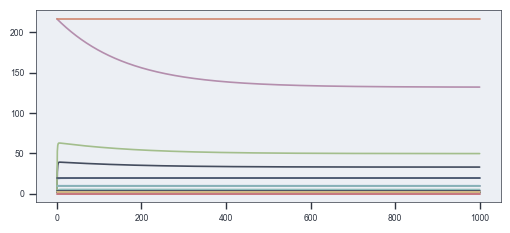

In [6]:
initial_states = list(ORIGINAL_STATES)
initial_states[-1] = 2
model.setInitialStates(initial_states)

solver = model.getSolver()

model.setParameterByName('kf', 0.5)
model.setTimepoints(np.linspace(0, 1000, 1000))
rdata = amici.runAmiciSimulation(model, solver)

fig, axes = plt.subplots(figsize=(6,2.5))
axes.plot(rdata['t'], rdata['x'])
plt.show()

## Calculate *In silico* target functions 

In [7]:
solver = model.getSolver()
model.setParameterByName('kf', 0.5)
model.setInitialStates(rdata['x'][-1])
model.setTimepoints(np.linspace(0, 10, 1000))
rdata = amici.runAmiciSimulation(model, solver)

time_points = np.linspace(U_fluctuations.index[0], U_fluctuations.index[-1], len(U_fluctuations))
data_points = []

""" Only start a new flow every 60 seconds, because flows were held constant inbetween"""
for time, DHA in U_fluctuations[::6].items():
    model.setTimepoints(np.linspace(0, 1, 6))
    initial_states = rdata['x'][-1]
    initial_states[-1] = DHA
    model.setInitialStates(initial_states)
    rdata = amici.runAmiciSimulation(model, solver)

    data_points.append(rdata['x'][:, :87])

data = np.array(data_points).reshape(203*6, 87)
data = pd.DataFrame(data=data, columns=model.getStateIds()[:87], index=time_points)

### Plot target functions

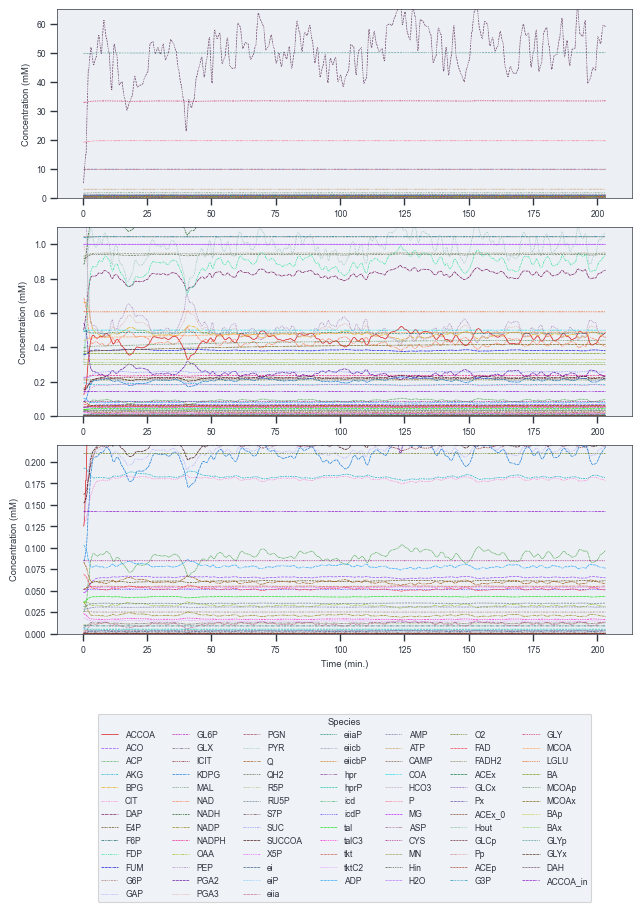

In [8]:
fig, axes = plt.subplots(3, figsize=(6.3,9), constrained_layout=True)

sns.lineplot(ax=axes[0], data=data, palette=cc.glasbey_dark[:data.shape[1]], lw=0.5, alpha=0.9, legend=None)
sns.lineplot(ax=axes[1], data=data, palette=cc.glasbey_dark[:data.shape[1]], lw=0.5, alpha=0.9, legend=None)
sns.lineplot(ax=axes[2], data=data, palette=cc.glasbey_dark[:data.shape[1]], lw=0.5, alpha=0.9)

axes[0].set_ylim(0, 65)
axes[1].set_ylim(0, 1.1)
axes[2].set_ylim(0, 0.22)

axes[2].set_xlabel("Time (min.)")
axes[0].set_ylabel("Concentration (mM)")
axes[1].set_ylabel("Concentration (mM)")
axes[2].set_ylabel("Concentration (mM)")

axes[2].legend(ncols=7, title='Species', loc='upper center', bbox_to_anchor=(0.5, -0.4))

plt.show()

## Training and plots with total results


invalid value encountered in scalar divide



invalid value encountered in scalar divide



invalid value encountered in scalar divide



invalid value encountered in scalar divide



divide by zero encountered in scalar divide



divide by zero encountered in scalar divide



invalid value encountered in scalar divide



invalid value encountered in scalar divide



divide by zero encountered in scalar divide



divide by zero encountered in scalar divide



invalid value encountered in scalar divide



invalid value encountered in scalar divide



invalid value encountered in scalar divide




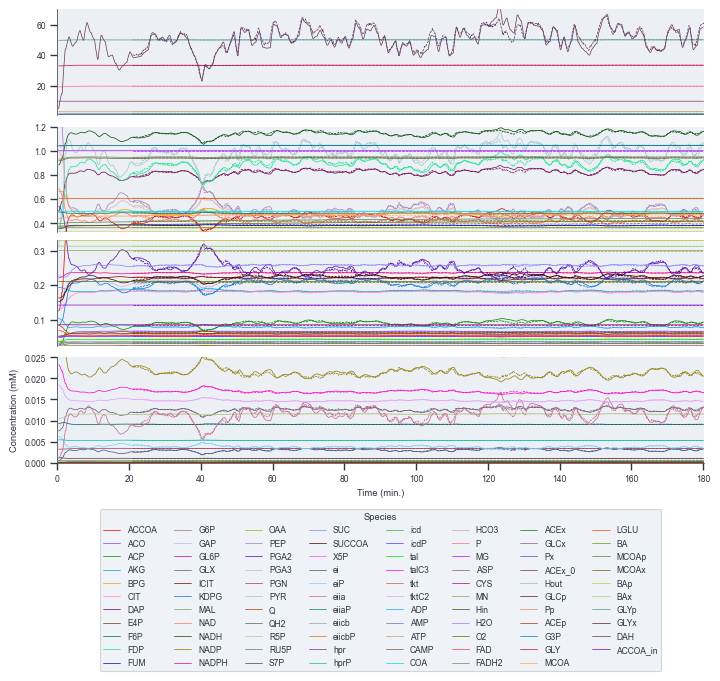

In [9]:
fig, axes = plt.subplots(4, figsize=(7.087,6.7), constrained_layout=True, gridspec_kw={
                            'hspace': -0.33,})

def nmse(y_pred, y_true):
    return ((y_pred - y_true)**2).sum()/((y_true - y_true.mean())**2).sum()

N_skip = 118 # Timepoints to skip completely (1 timepoint == 10 seconds)
N_train = 298 # Timepoints to include in training (after substracting N_skip timepoints) (1800 seconds == 30 minutes)
N_test = 1079 # Timepoints to include in testing (after subtracting N_train timepoints) (7810 seconds ~= 130 minutes)
N_offset_correction = 6 # Shift of the data and timepoints because of misalignedment between input and data/timepoints


data_test = []
data_test_lin = []
MSE_tests = []
MSE_lin_tests = []
R2_tests = []
R2_lin_tests = []

for i, s in enumerate(model.getStateIds()[:87]):
    Y_train = data.values[N_skip:N_train, i]
    X_train = X.iloc[N_skip-N_offset_correction:N_train-N_offset_correction]

    Y_test = data.values[N_train:N_test, i]

    reg = linear_model.Ridge(alpha=0.00005)
    reg_lin = linear_model.Ridge(alpha=0.00005)

    reg.fit(X_train, Y_train)
    reg_lin.fit(U_fluctuations.values[N_skip-6:N_train-6].reshape(-1, 1), Y_train)

    Y_pred = reg.predict(X.iloc[N_skip:N_test])
    train_mse = nmse(reg.predict(X_train), Y_train)
    test_mse = nmse(Y_pred, data.values[N_skip+N_offset_correction:N_test+N_offset_correction,i])
    test_r2 = reg.score(X.iloc[N_skip:N_test], data.values[N_skip+N_offset_correction:N_test+N_offset_correction,i])
    data_test.append(Y_pred)
    MSE_tests.append(test_mse)
    R2_tests.append(test_r2)

    
    Y_pred_lin = reg_lin.predict(U_fluctuations.iloc[N_skip:N_test].values.reshape(-1, 1))
    test_mse_lin = nmse(Y_pred_lin, data.values[N_skip+N_offset_correction:N_test+N_offset_correction,i])
    test_r2_lin = reg_lin.score(U_fluctuations.iloc[N_skip:N_test].values.reshape(-1, 1), data.values[N_skip+N_offset_correction:N_test+N_offset_correction,i])

    data_test_lin.append(Y_pred_lin)
    MSE_lin_tests.append(test_mse_lin)
    R2_lin_tests.append(test_r2_lin)


    axes[0].plot(time_points[N_skip+N_offset_correction:N_test+N_offset_correction], Y_pred, '--', lw=0.5, color=cc.glasbey_dark[i])
    axes[1].plot(time_points[N_skip+N_offset_correction:N_test+N_offset_correction], Y_pred, '--', lw=0.5, color=cc.glasbey_dark[i])
    axes[2].plot(time_points[N_skip+N_offset_correction:N_test+N_offset_correction], Y_pred, '--', lw=0.5, color=cc.glasbey_dark[i])
    axes[3].plot(time_points[N_skip+N_offset_correction:N_test+N_offset_correction], Y_pred, '--', lw=0.5, color=cc.glasbey_dark[i])

    axes[0].plot(time_points[:N_test], data.values[:N_test][:,i], lw=0.5, color=cc.glasbey_dark[i])
    axes[1].plot(time_points[:N_test], data.values[:N_test][:,i], lw=0.5, color=cc.glasbey_dark[i])
    axes[2].plot(time_points[:N_test], data.values[:N_test][:,i], lw=0.5, color=cc.glasbey_dark[i])
    axes[3].plot(time_points[:N_test], data.values[:N_test][:,i], lw=0.5, color=cc.glasbey_dark[i], label=s)

MSE_tests = np.array(MSE_tests)
MSE_lin_tests = np.array(MSE_lin_tests)
R2_tests = np.array(R2_tests)
R2_lin_tests = np.array(R2_lin_tests)

MSE_tests[~np.isfinite(MSE_tests)] = 0
MSE_lin_tests[~np.isfinite(MSE_lin_tests)] = 0
R2_tests[~np.isfinite(R2_tests)] = 0
R2_lin_tests[~np.isfinite(R2_lin_tests)] = 0


axes[0].set_ylim(1.2, 70)
axes[1].set_ylim(0.33, 1.2)
axes[2].set_ylim(0.025, 0.33)
axes[3].set_ylim(0, 0.025)
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[2].set_xticks([])
axes[3].set_xticks([i*20 for i in range(10)])
axes[3].legend(loc='upper center', title='Species', bbox_to_anchor=(0.5, -0.4), ncol=8)
axes[0].set_xlim(0, time_points[N_test])
axes[1].set_xlim(0, time_points[N_test])
axes[2].set_xlim(0, time_points[N_test])
axes[3].set_xlim(0, time_points[N_test])
axes[3].set_xlabel("Time (min.)")
axes[3].set_ylabel("Concentration (mM)")

sns.despine(ax=axes[0], bottom=True)
sns.despine(ax=axes[1], bottom=True)
sns.despine(ax=axes[2], bottom=True)
sns.despine(ax=axes[3])
save_si("si_dynamics_predictions_full")

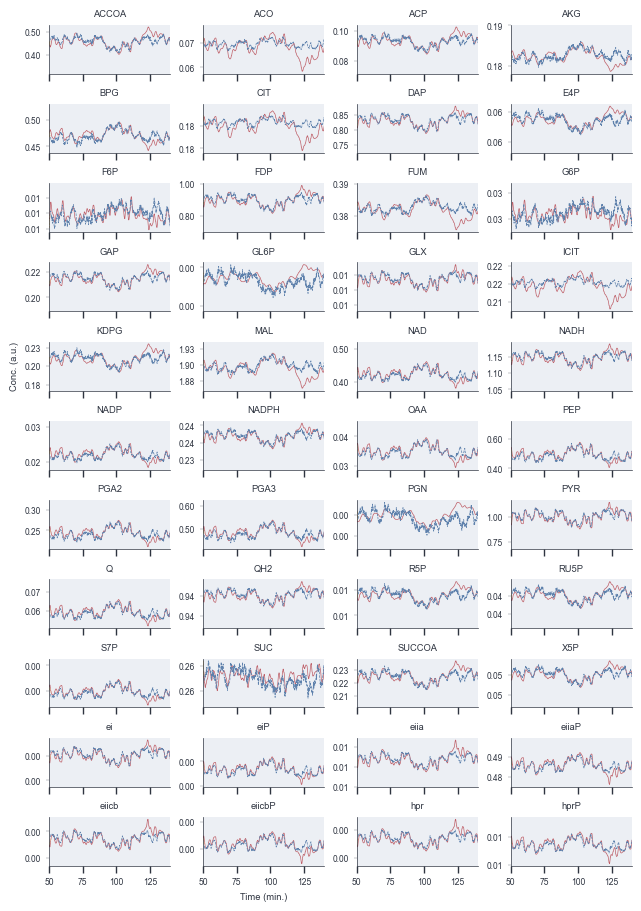

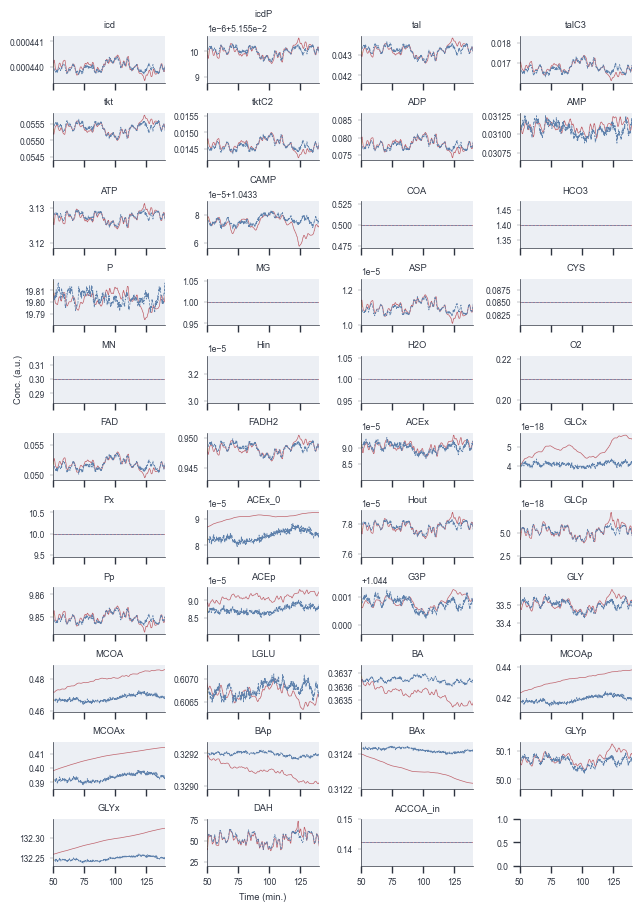

In [10]:
from matplotlib import ticker

SEL_labels = np.array(model.getStateIds()[:44])
SEL_label_idx = [model.getStateIds().index(l) for l in SEL_labels]
fig, axes = plt.subplots(11,4, figsize=(6.3,9), sharex=True, constrained_layout=True, 
                            gridspec_kw={'hspace': 0.1,}
                        )
axes = axes.flatten()


for i, (idx, l) in enumerate(zip(SEL_label_idx, SEL_labels)):
    axes[i].set_title(l)
    axes[i].plot(time_points[N_skip:N_test], data.values[N_skip:N_test][:,idx], color=f'C0', lw=0.5)
    axes[i].plot(time_points[N_skip+6:N_train+6], data_test[idx][:N_train-N_skip], color=f'C2', ls='dashed', lw=0.5)
    axes[i].plot(time_points[N_train+6:N_test+6], data_test[idx][N_train-N_skip:N_test], color=f'C8', ls='dashed', lw=0.5)
    axes[i].set_xlim(time_points[N_skip], time_points[N_test])
    axes[i].set_xlim(50, 140)
    axes[i].set_xlabel(None)
    axes[i].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    axes[i].tick_params(axis='y', width=0.2, length=2.5, labelsize=6)
    sns.despine()


axes[16].set_ylabel("Conc. (a.u.)")
axes[-3].set_xlabel("Time (min.)")

save_si("si_dynamics_predictions_a")

SEL_labels = np.array(model.getStateIds()[44:87])
SEL_label_idx = [model.getStateIds().index(l) for l in SEL_labels]
fig, axes = plt.subplots(11,4, figsize=(6.3,9), sharex=True, constrained_layout=True, 
                            gridspec_kw={'hspace': 0.1,}
                        )
axes = axes.flatten()

for i, (idx, l) in enumerate(zip(SEL_label_idx, SEL_labels)):
    axes[i].set_title(l)
    axes[i].plot(time_points[N_skip:N_test], data.values[N_skip:N_test][:,idx], color=f'C0', lw=0.5)
    axes[i].plot(time_points[N_skip+6:N_train+6], data_test[idx][:N_train-N_skip], color=f'C2', ls='dashed', lw=0.5)
    axes[i].plot(time_points[N_train+6:N_test+6], data_test[idx][N_train-N_skip:N_test], color=f'C8', ls='dashed', lw=0.5)
    axes[i].set_xlim(time_points[N_skip], time_points[N_test])
    axes[i].set_xlim(50, 140)
    axes[i].ticklabel_format(axis='y', style='sci')
    axes[i].set_xlabel(None)
    axes[i].tick_params(axis='y', width=0.2, length=2.5, labelsize=6)
    sns.despine()

axes[16].set_ylabel("Conc. (a.u.)")
axes[-3].set_xlabel("Time (min.)")

save_si("si_dynamics_predictions_b")


## Compare NMSE scores against linear predictor and plot

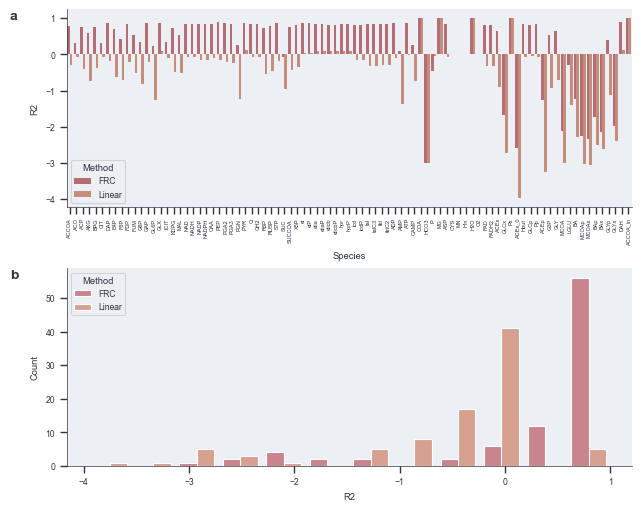

In [11]:
tests_r2_df = pd.DataFrame({'id': model.getStateIds()[:87], 'FRC': R2_tests, 'Linear': R2_lin_tests})
tests_r2_df = pd.melt(tests_r2_df, id_vars='id', var_name="Method", value_name="R2")

fig, axes = plt.subplots(2, 1, figsize=(6.3, 5), constrained_layout=True)
sns.barplot(tests_r2_df, ax=axes[0], x='id', y='R2', hue='Method', linewidth=0)
axes[0].tick_params(axis='x', rotation=90, labelsize=4)
axes[0].set_xlabel("Species")
sns.histplot(tests_r2_df, ax=axes[1], x='R2', hue='Method', multiple="dodge", shrink=0.8)
sns.despine()
axes[0].text(-0.1, 0.95, 'a', transform=axes[0].transAxes, size=10, weight='bold')
axes[1].text(-0.1, 0.95, 'b', transform=axes[1].transAxes, size=10, weight='bold')
save_si("si_dynamics_errors_r2")

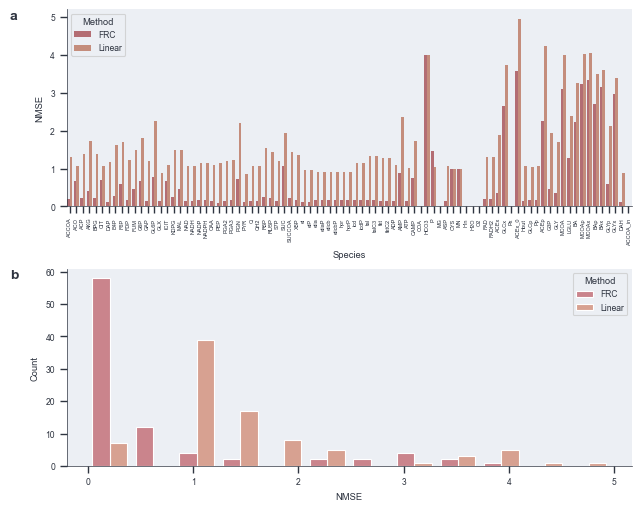

In [12]:
tests_df = pd.DataFrame({'id': model.getStateIds()[:87], 'FRC': MSE_tests, 'Linear': MSE_lin_tests})
tests_df = pd.melt(tests_df, id_vars='id', var_name="Method", value_name="NMSE")

fig, axes = plt.subplots(2, 1, figsize=(6.3, 5), constrained_layout=True)
sns.barplot(tests_df, ax=axes[0], x='id', y='NMSE', hue='Method', linewidth=0)
axes[0].tick_params(axis='x', rotation=90, labelsize=4)
axes[0].set_xlabel("Species")
sns.histplot(tests_df, ax=axes[1], x='NMSE', hue='Method', multiple="dodge", shrink=0.8)
sns.despine()
axes[0].text(-0.1, 0.95, 'a', transform=axes[0].transAxes, size=10, weight='bold')
axes[1].text(-0.1, 0.95, 'b', transform=axes[1].transAxes, size=10, weight='bold')
save_si("si_dynamics_errors")

## Plots figure 3c - Results Pyr., 3PG, AMP

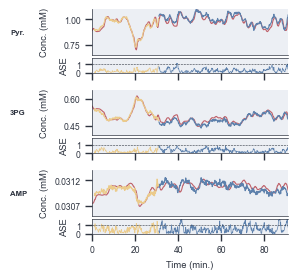

In [13]:
SEL_labels = ['PYR', 'PGA3', 'AMP']
SEL_label_idx = [model.getStateIds().index(l) for l in SEL_labels]

fig = plt.figure(figsize=(3.2, 2.8)
                        )
outer_grid = fig.add_gridspec(3,1)
axes = []
for i, (idx, l) in enumerate(zip(SEL_label_idx, SEL_labels)):
    inner_grid = outer_grid[i].subgridspec(2,1, hspace=0.1, height_ratios=[3,1])
    ax1 = fig.add_subplot(inner_grid[0])
    ax2 = fig.add_subplot(inner_grid[1])

    ax1.plot(time_points[N_skip:N_test], data.values[N_skip:N_test][:,idx], color=f'C0', lw=0.8)
    ax1.plot(time_points[N_skip+N_offset_correction:N_train+N_offset_correction], data_test[idx][:N_train-N_skip], color=f'C2', ls='solid', lw=0.8)
    ax1.plot(time_points[N_train+N_offset_correction:N_test+N_offset_correction], data_test[idx][N_train-N_skip:N_test], color=f'C8', ls='solid', lw=0.8)

    # Mean Average Deviation of train data (naive mean-predictor absolute error)
    MAD_train = abs(data.values[N_skip+N_offset_correction:N_train+N_offset_correction][:,idx]-data.values[N_skip+N_offset_correction:N_train+N_offset_correction][:,idx].mean()).mean() 

    ax2.plot(time_points[N_skip+N_offset_correction:N_train+N_offset_correction], abs(data.values[N_skip+N_offset_correction:N_train+N_offset_correction][:,idx]-data_test[idx][:N_train-N_skip])/MAD_train, color=f'C2', ls='solid', lw=0.5)
    ax2.plot(time_points[N_train+N_offset_correction:N_test+N_offset_correction], abs(data.values[N_train+N_offset_correction:N_test+N_offset_correction][:,idx]-data_test[idx][N_train-N_skip:N_test])/MAD_train, color=f'C8', ls='solid', lw=0.5)


    ax2.axhline(0, color='black', lw=0.4)
    ax1.set_xlim(time_points[N_skip], time_points[N_test])
    sns.despine(ax=ax1, bottom=False)
    sns.despine(ax=ax2, top=False)

    axes.append(ax1)
    axes.append(ax2)
    ax1.set_xticks([], [])
    ax1.set_xlim(20, 51+60)
    ax2.set_xticks([20, 40, 60, 80, 100], [])
    ax2.set_xlim(20, 51+60)

axes[0].set_ylabel("Conc. (mM)")
axes[0].yaxis.set_label_coords(-0.22, 0.5)
axes[2].set_ylabel("Conc. (mM)")
axes[2].yaxis.set_label_coords(-0.22, 0.5)
axes[4].set_ylabel("Conc. (mM)")
axes[4].yaxis.set_label_coords(-0.22, 0.5)

axes[1].set_ylabel("ASE")
axes[1].yaxis.set_label_coords(-0.12, 0.5)
axes[3].set_ylabel("ASE")
axes[3].yaxis.set_label_coords(-0.12, 0.5)
axes[5].set_ylabel("ASE")
axes[5].yaxis.set_label_coords(-0.12, 0.5)

axes[5].set_xlabel("Time (min.)")
axes[0].set_ylim(0.65, 1.1)
axes[2].set_ylim(0.4, 0.65)
axes[4].set_ylim(0.0305, 0.0314)
axes[0].set_yticks([0.75, 1.00])
axes[2].set_yticks([0.45, 0.6])
axes[4].set_yticks([0.0307, 0.0312])
axes[1].set_yticks([0, 1, 2])
axes[3].set_yticks([0, 1, 2])
axes[5].set_yticks([0, 1, 2])

axes[1].set_ylim(0, 1.8)
axes[3].set_ylim(0, 1.8)
axes[5].set_ylim(0, 1.8)

axes[1].axhline(1.0, ls="--", lw=0.4, color="C9")
axes[3].axhline(1.0, ls="--", lw=0.4, color="C9")
axes[5].axhline(1.0, ls="--", lw=0.4, color="C9")

axes[0].text(-0.42, 0.5, 'Pyr.', transform=axes[0].transAxes, va='center', fontsize='small' , fontweight='bold')
axes[2].text(-0.42, 0.5, '3PG', transform=axes[2].transAxes, va='center', fontsize='small', fontweight='bold')
axes[4].text(-0.42, 0.5, 'AMP', transform=axes[4].transAxes, va='center', fontsize='small', fontweight='bold')

axes[-1].set_xticks([20, 40, 60, 80, 100], [0, 20, 40, 60, 80])
axes[1].set_xlim(20, 51+60)

plt.tight_layout()

save_plot("dynamics_predictions")


## Plots figure 3d - Comparison plots

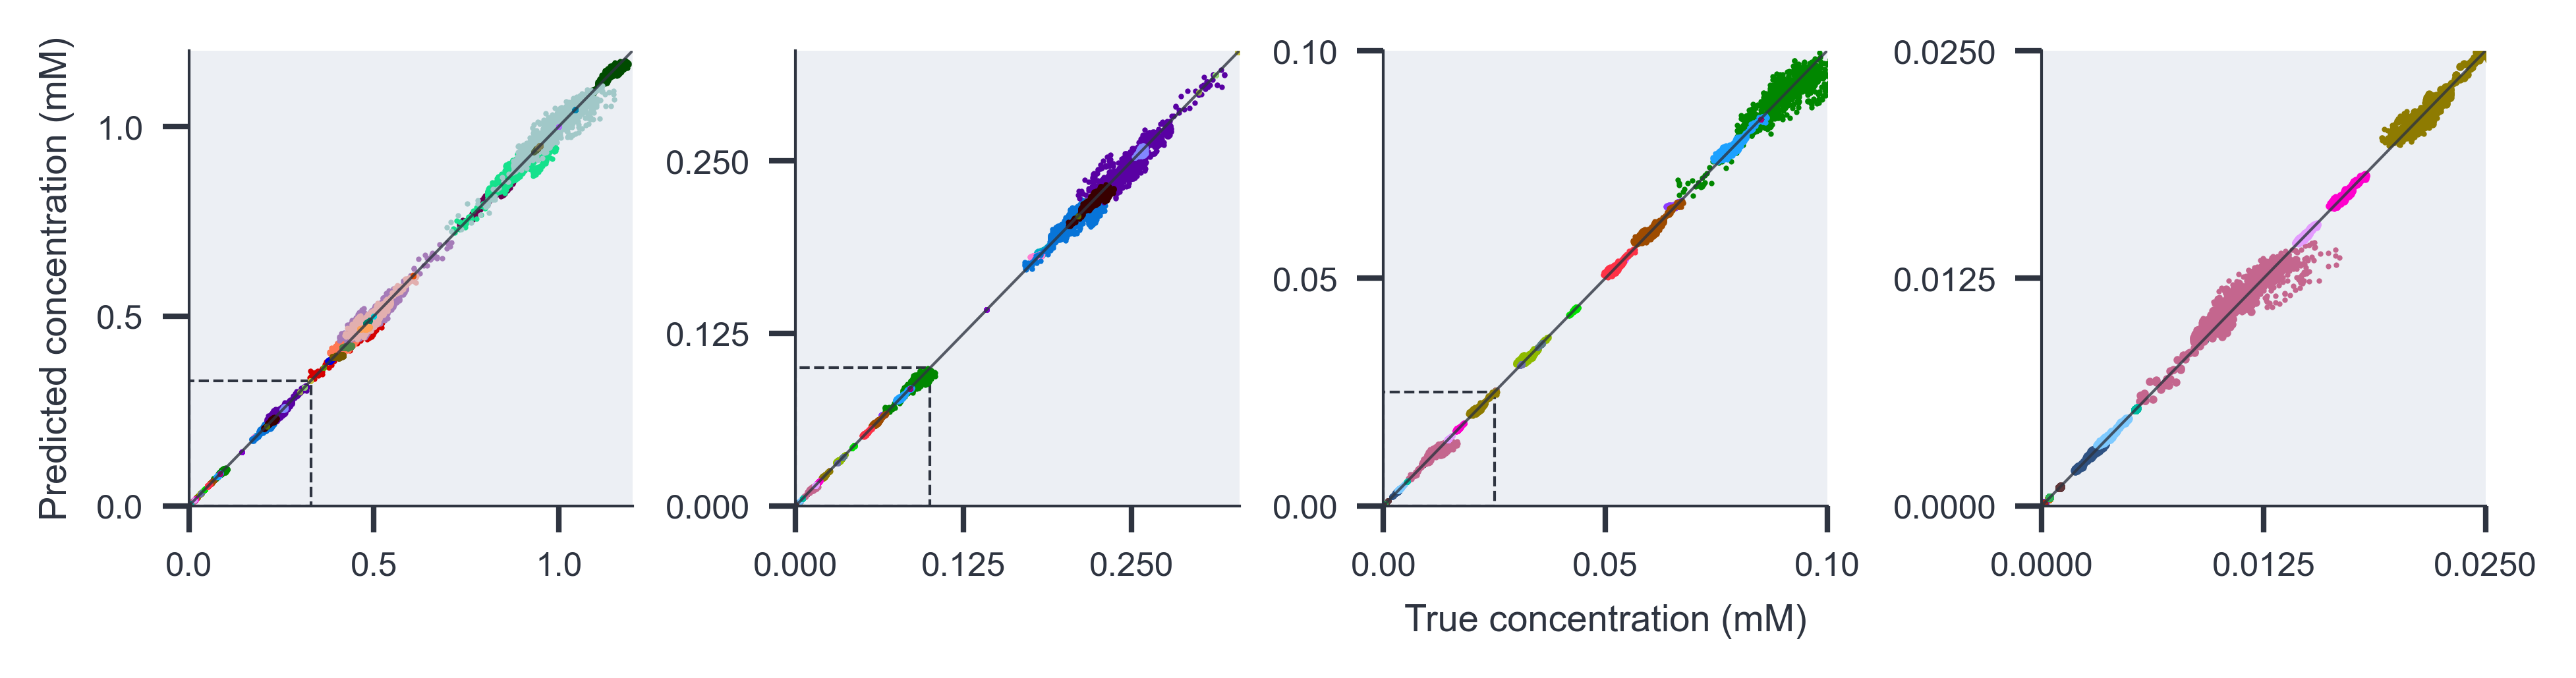

In [14]:
fig, axes = plt.subplots(1,4, figsize=(6.4,1.6), constrained_layout=True, 
                        dpi=600,
                        )
axes = axes.flatten()

from matplotlib.patches import Rectangle

axes[0].add_patch(Rectangle((0, 0), 0.33, 0.33, fill=True, ec='C9', lw=0.5, ls='--', facecolor='#eceff4'))
axes[1].add_patch(Rectangle((0, 0), 0.1, 0.1, fill=True, ec='C9', lw=0.5, ls='--', facecolor='#eceff4'))
axes[2].add_patch(Rectangle((0, 0), 0.025, 0.025, fill=True, ec='C9', lw=0.5, ls='--', facecolor='#eceff4'))

axes[0].plot([0,10],[0,10], color='C9', lw=0.5, alpha=0.8)
axes[1].plot([0, 1],[0, 1], color='C9', lw=0.5, alpha=0.8)
axes[2].plot([0,1e3],[0,1e3], color='C9', lw=0.5, alpha=0.8)
axes[3].plot([0,1e3],[0,1e3], color='C9', lw=0.5, alpha=0.8)

SEL_labels = np.array(model.getStateIds()[:87])
SEL_label_idx = [model.getStateIds().index(l) for l in SEL_labels]

MEAN = data.values[N_train:N_test].mean(axis=0)

for i, (idx, l) in enumerate(zip(SEL_label_idx, SEL_labels)):
    axes[0].scatter(data.values[N_skip+6:N_train+6][:,idx],data_test[idx][:N_train-N_skip], color=cc.glasbey_dark[i], lw=0, label=l, rasterized=True, s=1.0)
    axes[0].scatter(data.values[N_train+6:N_test+6][:,idx],data_test[idx][N_train-N_skip:N_test], color=cc.glasbey_dark[i], lw=0, rasterized=True, s=1.0)
    axes[1].scatter(data.values[N_skip+6:N_train+6][:,idx],data_test[idx][:N_train-N_skip], color=cc.glasbey_dark[i], lw=0, label=l, rasterized=True, s=1.0)
    axes[1].scatter(data.values[N_train+6:N_test+6][:,idx],data_test[idx][N_train-N_skip:N_test], color=cc.glasbey_dark[i], lw=0, rasterized=True, s=1.0)
    axes[2].scatter(data.values[N_skip+6:N_train+6][:,idx],data_test[idx][:N_train-N_skip], color=cc.glasbey_dark[i], lw=0, label=l, rasterized=True, s=1.0)
    axes[2].scatter(data.values[N_train+6:N_test+6][:,idx],data_test[idx][N_train-N_skip:N_test], color=cc.glasbey_dark[i], lw=0, rasterized=True, s=1.0)
    axes[3].scatter(data.values[N_skip+6:N_train+6][:,idx],data_test[idx][:N_train-N_skip], color=cc.glasbey_dark[i], lw=0.5, label=l, rasterized=True, s=1.0)
    axes[3].scatter(data.values[N_train+6:N_test+6][:,idx],data_test[idx][N_train-N_skip:N_test], color=cc.glasbey_dark[i], lw=0, rasterized=True, s=1.0)
axes[0].set_ylabel("Predicted concentration (mM)")
axes[2].set_xlabel("True concentration (mM)")

axes[0].set_xlim(0, 1.2)
axes[0].set_ylim(0, 1.2)
axes[1].set_xlim(0, 0.33)
axes[1].set_ylim(0, 0.33)
axes[2].set_xlim(0, 0.1)
axes[2].set_ylim(0, 0.1)
axes[3].set_xlim(0, 0.025)
axes[3].set_ylim(0, 0.025)

axes[0].set_xticks([0, 0.5, 1.0])
axes[0].set_yticks([0, 0.5, 1.0])
axes[1].set_xticks([0, 0.125, 0.25])
axes[1].set_yticks([0, 0.125, 0.25])
axes[2].set_xticks([0, 0.05, 0.1])
axes[2].set_yticks([0, 0.05, 0.1])
axes[3].set_xticks([0, 0.0125, 0.025])
axes[3].set_yticks([0, 0.0125, 0.025])

sns.despine()
save_plot('dynamics_score')
